# Predicting helpful reviews using machine learning and specifical classification
----------------------
## Problem
### It has been showed that over last past 10 years, global retail e-commerce has been explosive growth. Without experience of product commonalities, customers will heavily rely on other reviewers for the decision making for the online shopping. However, with amount of information from reviewers, it is important for a website to identify the useful, valid, and reliable reviews to save help customers. Useful reviews also can in turn to help business to improve their products and understand customers' need.

## Goal
### The goal of this project is to mine 9,000,000 book reviews from Amazon.com to understand the features of reviews for helpfulness and develop preliminary classification models to predict helpfulness of a review foods


## Data source
### http://jmcauley.ucsd.edu/data/amazon/
#### Data information
    "reviewerID": "A2SUAM1J3GNN3B"
    "asin": "0000013714"
    "reviewerName": "J. McDonald"
    "helpful": [2, 3]
    "reviewText": "Great purchase though!",
    "overall": 5.0,
    "summary": "Heavenly Highway Hymns",
    "unixReviewTime": 1252800000,
    "reviewTime": "09 13, 2009"

-------------------------------------------------
## _1. Preparing Amazon book dataset_

### 1.1. Load json data from bigquery ( here we imported ~100,000 data)
### 1.2. Check data
### 1.3. Label helpful and unhelpful reviews
        helful_vot/total vot > 75% ==> helpfulness 
        helful_vot/total vot <= 75% ==> unhelpfulness

In [ ]:
## for data imported from google cloud
##########################################
## CONFIG FOR BIGQUERY
##########################################

## Setting configuration for bigquery
## Save data as dataframe 

from bigquery import get_client

# BigQuery project id as listed in the Google Developers Console.
project_id = 'springboard-project'

# Service account email address as listed in the Google Developers Console.
service_account = 'python-pandas@springboard-project.iam.gserviceaccount.com'

# PKCS12 or PEM key provided by Google.
key = '/Users/tancy/SpringBoardProject-b3a58f067389.p12'

client = get_client(project_id, service_account=service_account,
                    private_key_file=key, readonly=True)

In [ ]:
##########################################
## BIGQUERY TO DATAFRAME
##########################################

import pandas as pd

# to communicate with Google BigQuery
from pandas.io import gbq

amazon_book_sample_query = """
SELECT
    reviewerID,
    asin,
    unixReviewTime,
    overall,
    reviewText,
    summary,
    helpful_vot,
    tot_vot,

FROM
    (SELECT * FROM [springboard-project:AmazonReview.book2_small_sample])
    
"""

try:
    ABS_df = gbq.read_gbq(amazon_book_sample_query, project_id=project_id)
except:
    print 'Error reading the dataset'


    
#save to pickle
%timeit ABS_df.to_pickle('AmazonBook_Review.p')

In [1]:
##########################################
## 1.1 IMPORT DATA IN PANDAS
############################################
import pandas as pd

# load data from local site
ABS_df= pd.read_pickle('AmazonBook_Review.p')

In [2]:
##########################################
## 1.2 CHECK DATA IN PANDAS
############################################

# change column name 
ABS_df = ABS_df.rename(columns={'overall': 'reviewRating'})

print "Total data:", str(ABS_df.shape)
ABS_df.head(2)

Total data: (100225, 8)


,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1


### Here, we randomly selected ~100,000 reviews (1%) from total amazon book reviews

In [3]:
##########################################
## 1.3 LABEL HELPFULNESS
#########################################
import numpy as np

def label_Helpfulness(row):
    if row['help_prop'] > 0.75:
           return 'helpful'
    else: 
           return 'unhelpful'

ABS_df['help_prop'] = ABS_df.helpful_vot.div(ABS_df.tot_vot, axis=0)
#ABS_df = ABS_df[np.isfinite(ABS_df['help_prop'])] ### should we exclude reviews with no vote ? ###
ABS_df['helpIndx'] = ABS_df.apply(label_Helpfulness, axis=1)

ABS_df.head(2)

,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot,help_prop,helpIndx
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1,1.0,helpful
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1,1.0,helpful


-----------------
## _2. Preliminary Analysis_
### 2.1 Descriptive statistics
### 2.2 Distribution of reviewer rating (1 to 5)
### 2.3 Distribution of helful proportion for reviews
### 2.4 Distribution of reviewer rating for helpfulness
### 2.5 An example of a product for reviewer rating and helpfulness
### 2.6 Helpfulness for the length of text

In [4]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print "================================================"

### Total reviews
print "Number of reviews:" + str(len(ABS_df))

### How many unique reviewers?
reviewer_prop = float(len(ABS_df.reviewerID.unique()))/len(ABS_df.index)
print "Prop of unique reviewers:" + str(round(reviewer_prop,3))

### How many unique products?
product_prop = float(len(ABS_df.asin.unique()))/len(ABS_df.index)
print "Prop of unique products:" + str(round(product_prop,3))

### average star score
print("Average rating score: " + str(round(ABS_df.reviewRating.mean(),3)))

### average helpful 
print("Average helpful pcd:" + str(round(ABS_df.help_prop.mean(),3)))
print "================================================"

Number of reviews:100225
Prop of unique reviewers:0.768
Prop of unique products:0.666
Average rating score: 4.251
Average helpful pcd:0.734


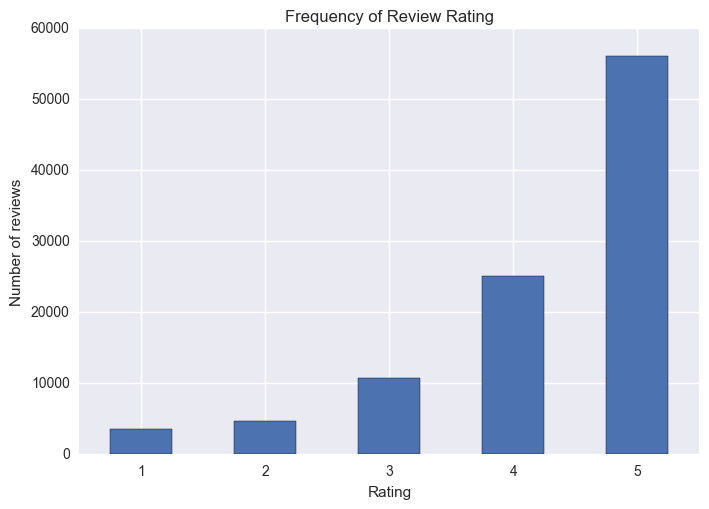

In [4]:
##########################################
## 2.2 DISTRIBUTION OF REVIEWER RATING
########################################## 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ABS_df.groupby('reviewRating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

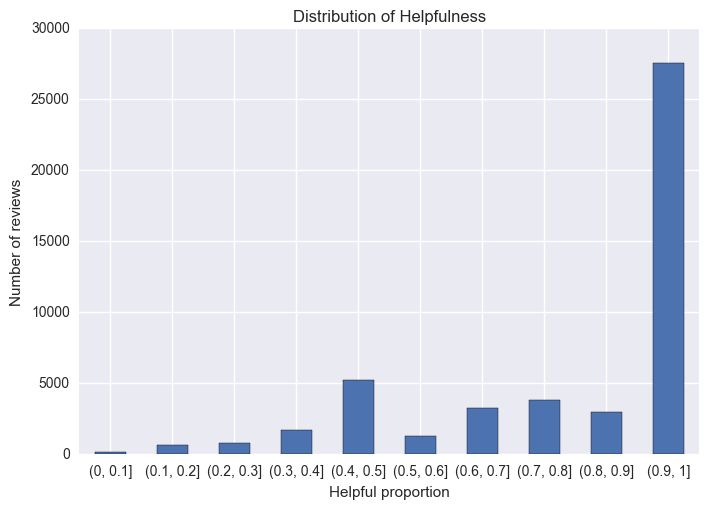

In [6]:
##########################################
## 2.3 DISTRIBUTION OF HELPFULNESS
########################################## 

cutoff = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


Dist_help = ABS_df.groupby([pd.cut(ABS_df['help_prop'], bins = cutoff)]).size()
Dist_help.plot(kind='bar')

plt.title("Distribution of Helpfulness")
plt.xlabel("Helpful proportion")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

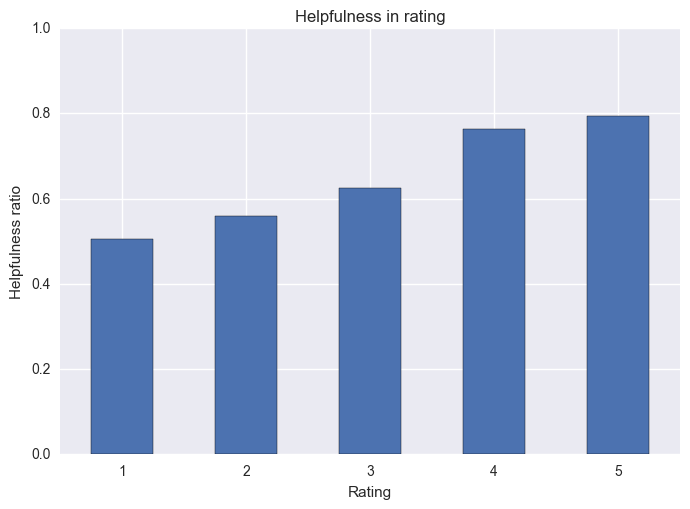

In [7]:

##########################################
## 2.4 DISTRIBUTION OF RATING FOR HELPFULNESS
########################################## 
ABS_df.groupby('reviewRating')['help_prop'].mean().plot(kind='bar')
plt.title("Helpfulness in rating")
plt.xlabel("Rating")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.show()

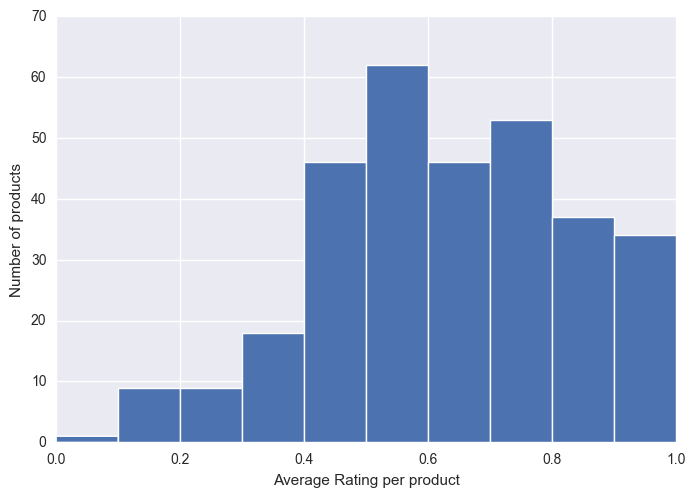

In [8]:
df = ABS_df.copy()
df = df[np.isfinite(df['help_prop'])]
grp = df.groupby('asin')
counts = grp.asin.count()        # number of reviews by each critic
means = grp.help_prop.mean()     # average freshness for each critic

means[counts > 5].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per product")
plt.ylabel("Number of products")
plt.show()

### ==> preliminary result showed the customers have tendency to vote more helpfulness for higher rating reviews. 

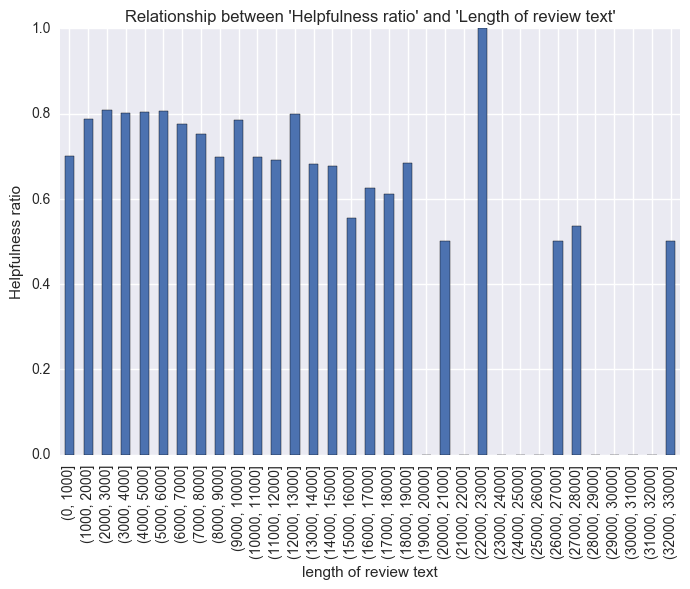

In [5]:
##########################################
## 2.6 HELPFULNESS FOR LENGTH OF TEXT
########################################## 
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = max(ABS_df.text_len)
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen+1000,1000)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Relationship between 'Helpfulness ratio' and 'Length of review text'")
plt.ylim([0, 1])

plt.show()

### ==> considering all data, it seems that helpfulness for a review increased to 80% when text length increased to 2000. When the text length more than 6000, the helpfulness decreased. 

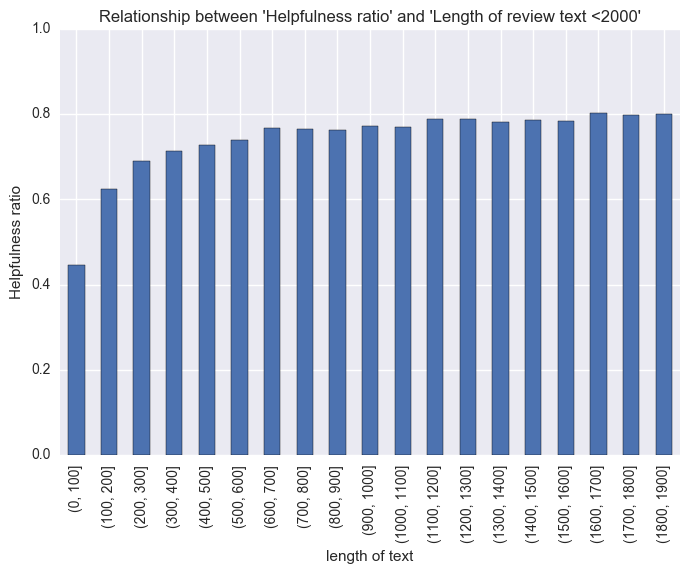

In [10]:
## check helpfulness ration below 2000 words
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = 2000 ## 
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen,100)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of text")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.title("Relationship between 'Helpfulness ratio' and 'Length of review text <2000'")
plt.show()

### ==> Specifically, helpfulness increased to 80% when text length increased to 700. After 700 words, there is no difference of the helpfulness ratio.

-----------
## _3. Text Preprocessing_
### 3.1 Subset data for modeling
        total vote >=2 & text_len >=2
### 3.2 Statistic description of subset data 
### 3.3 Text length between helpfulness and unhelpfulness
### 3.4 Pair correlation between 'reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx'

In [6]:
###################
## 3.1 SUBSET DATA
###################

## select total vote >= 2
subset_ABS_df = ABS_df[(ABS_df.tot_vot>=2) & (ABS_df.text_len>=2)]

class_counts = subset_ABS_df.groupby('helpIndx').size()
help_proportion = round(class_counts[0]/float(class_counts.sum()),3)
unhelp_proportion = round(class_counts[1]/float(class_counts.sum()),3)

print "==========================================================="
print "Number of helpfulness (>75%) {}, proportion is {}".format(class_counts[0], help_proportion)
print "Number of unhelpfulness      {}, proportion is {}".format(class_counts[1], unhelp_proportion)
print "=========================================================="


Number of helpfulness (>75%) 17864, proportion is 0.513
Number of unhelpfulness      16948, proportion is 0.487


### ==> the proportion between helpfulness and unhelpfulness is 1.05 vs. 1 

In [12]:
##########################
## 3.2 STATISTIC SUMMARY 
#########################
from pandas import set_option
set_option('display.width', 100)
set_option('precision', 3)
print subset_ABS_df.groupby('helpIndx').describe()

                 help_prop  helpful_vot  reviewRating   text_len    tot_vot  unixReviewTime
helpIndx                                                                                   
helpful   count  17864.000    17864.000     17864.000  17864.000  17864.000       1.786e+04
          mean       0.952       12.165         4.310   1317.187     13.246       1.249e+09
          std        0.073       36.198         1.042   1268.458     39.821       1.288e+08
          min        0.752        2.000         1.000     26.000      2.000       8.507e+08
          25%        0.900        2.000         4.000    472.000      2.000       1.156e+09
          50%        1.000        5.000         5.000    945.500      5.000       1.288e+09
          75%        1.000       11.000         5.000   1744.000     12.000       1.359e+09
          max        1.000     1744.000         5.000  22620.000   1853.000       1.406e+09
unhelpful count  16948.000    16948.000     16948.000  16948.000  16948.000     

---
### ==> the mean (std) of helpfulness vs. unhelpfulness is 0.95 (0.07) vs. 0.48 (0.22)
### ==> the mean (std) of review rating between helpful index is 4.3 (1.0) vs. 3.6 (1.4)
### ==> the mean (std) of text length between helpful index is 1317 (1268) vs. 1029 (1307)

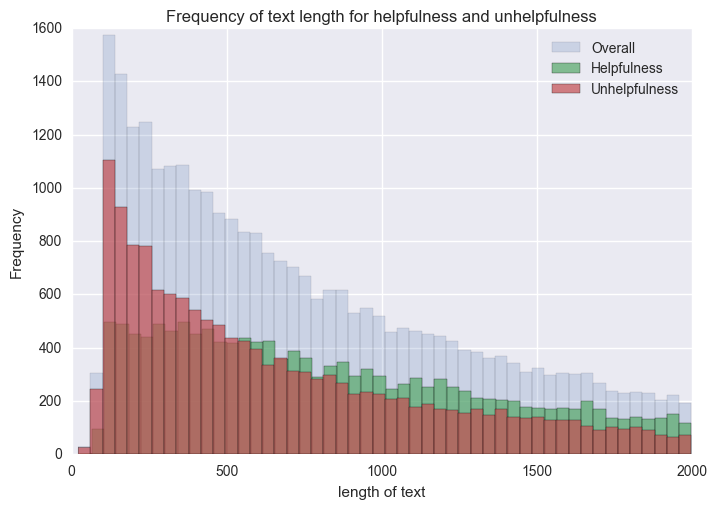

In [13]:
##########################
## 3.3 TEXT LENGTH  
########################### 

subset_ABS_df.text_len[subset_ABS_df.text_len<2000].plot(bins=50, kind='hist',alpha=0.2)
dhelp = subset_ABS_df.text_len[(subset_ABS_df['helpIndx']=='helpful') & (subset_ABS_df.text_len<2000)]
dunhelp = subset_ABS_df.text_len[(subset_ABS_df['helpIndx']=='unhelpful') & (subset_ABS_df.text_len<2000)]

dhelp.plot(bins=50, kind='hist', alpha=0.7)
dunhelp.plot(bins=50, kind='hist',alpha=0.7)

plt.legend(['Overall', 'Helpfulness', 'Unhelpfulness'])
plt.xlabel("length of text")
plt.ylabel("Frequency")
plt.title("Frequency of text length for helpfulness and unhelpfulness")
plt.show()


---

### ==> when text is shorter <500, customers treat the reveiw text is unhelpful

In [14]:
############################
## 3.4 PAIRWISE PEARSON CORR  
########################### 
names = ['reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx']
data = subset_ABS_df[names]
data[['helpIndx']] = np.where(data['helpIndx'] == 'helpful', 1, 0)
set_option('display.width', 100)
set_option('precision', 3)
correlations = data.corr(method='pearson')
print "================="
print(correlations)
print "================="

              reviewRating  help_prop  helpful_vot  text_len  tot_vot  helpIndx
reviewRating         1.000      0.312       -0.017     0.005   -0.086     0.269
help_prop            0.312      1.000        0.126     0.137    0.032     0.826
helpful_vot         -0.017      0.126        1.000     0.152    0.969     0.151
text_len             0.005      0.137        0.152     1.000    0.148     0.111
tot_vot             -0.086      0.032        0.969     0.148    1.000     0.075
helpIndx             0.269      0.826        0.151     0.111    0.075     1.000


/Users/tancy/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tancy/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


---
### ==> weak correlation (0.3) between 'review rating' and 'helpful proportion'
### ==> weak correlation (0.1) between 'text length' and 'helpful proportion'
### ==> High correlation (0.9) between 'helpful vote' and 'total vote', that is, if more customers read the review text, more customers treat the review text as helpful

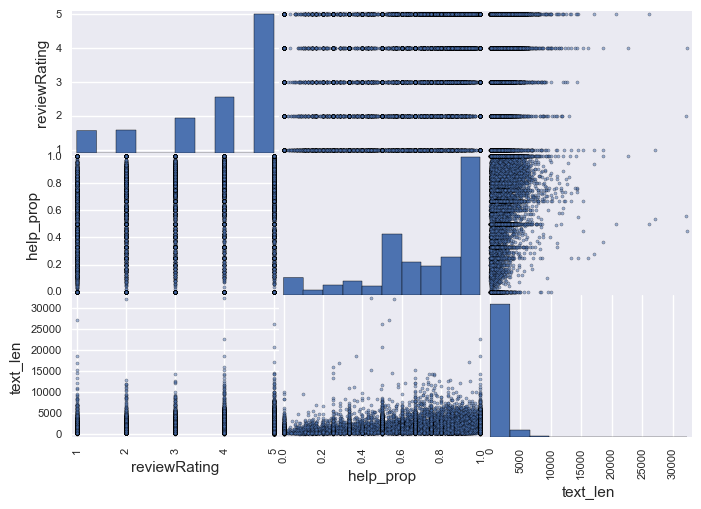

In [15]:
# scatter plot matrix
from pandas.tools.plotting import scatter_matrix
names = ['reviewRating','help_prop','text_len','helpIndx']
data = subset_ABS_df[names]
scatter_matrix(data)
plt.show()

----------
## _4. Bag of words_
### 4.1 Function to clean reviews to words
    * replaces all punctuation with spaces
    * converts the input string to lower case
    * splits the string to words
    * removes stop-words
### 4.2 Process to clean review
### 4.3 Manipulate clean text to be string instead of list (for count vectorize)
### 4.4 Extract features from strings
### 4.5 Transform a count matrix to tf-idf representation
### 4.6 Indentify top 20 features
### 4.7 word cloud of top 100 features

In [7]:
##########################################
## 4.1 FUNCTION TO CLEAN REVIEWS TO WORDS
##########################################
import re, string, nltk
from nltk.corpus import stopwords
from string import digits

def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw review), and 
    # the output is a single string (a preprocessed review)
    #
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

clean_s = subset_ABS_df.reviewText.apply(review_to_words)
clean_s.head()

2     got seventy six per cent book take book reads ...
3     thought story really well told totally disagre...
8     latest book former president jimmy carter cont...
9     naughton work gets better better read everythi...
11    book ton useful information however found most...
Name: reviewText, dtype: object

In [8]:
####################################
## 4.4 EXTRACT FEATURES FROM STRING
####################################
## generate single words along with 2 and 3 word phrases 
## select max 8000 terms 

from scipy.sparse import coo_matrix, vstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 3), max_features = 8000)
                             #token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'") # keep ? and !

# call `fit` to build the vocabulary
tfidf_review_text = vectorizer.fit_transform(clean_s)
feature_names = vectorizer.get_feature_names()


print "================================================"
print "Number of features:", len(feature_names)
print "Ten words for each feature:", feature_names[0:10]
print "================================================"
# vectorizer.vocabulary_

Number of features: 8000
Ten words for each feature: [u'aacute', u'aaron', u'abandon', u'abandoned', u'abby', u'abilities', u'ability', u'able', u'able get', u'able put']


In [9]:
########################################
## 4.5 TRANSFORM A COUNT MATRIX TO A TF
########################################

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()

# call `transform` to convert text to a bag of words
tfidf_matrix = transformer.fit_transform(tfidf_review_text) 

print "================================================"
print 'sparse matrix shape:', tfidf_matrix.shape # one row per review, one column per phrase
print 'number of non-zeros:', tfidf_matrix.nnz
print 'sparsity: %.2f%%' % (100.0 * tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print "================================================"

sparse matrix shape: (34812, 8000)
number of non-zeros: 2662365
sparsity: 0.96%


In [10]:
### convert CountVectorizer to density 
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
#len(phrase_scores)

In [11]:
############################################################################
## 4.6 IDENTIFY TOP 20 INFORMATIVE FEATURES AND THEIR INVERSE DOCUMENT FREQ
############################################################################

top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(feature_names[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

print pd.DataFrame(top)[:20]


       Feature_Name     Score
0      descriptions  0.241498
1             novel  0.236203
2                mc  0.192353
3         seventeen  0.183389
4              wade  0.180202
5         book take  0.179223
6   book reads like  0.177974
7            sophie  0.177372
8            eleven  0.176209
9           looking  0.176124
10           brains  0.171317
11       book reads  0.167824
12            dance  0.165119
13    romance novel  0.164755
14              man  0.162101
15          schools  0.155611
16             teen  0.148243
17        evolution  0.147320
18              per  0.146960
19          holding  0.146605


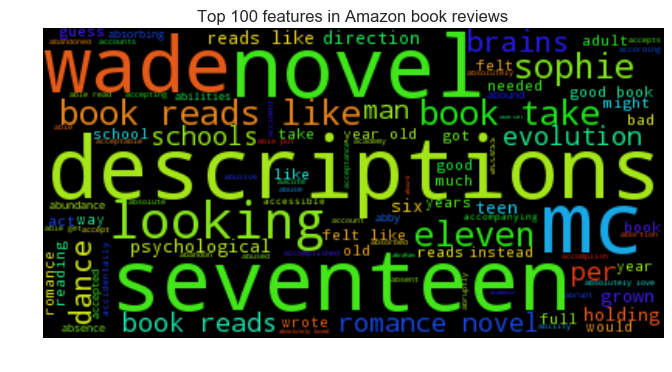

(0.0, 1.0, 0.0, 1.0)

In [13]:
############################################
## 4.7 PLOT WORDCLOUD OF TOP 100 FEATURES
############################################

### need wordcloud package by Andreas Mueller
### need Python’s imaging library PIL

top_wordDict = dict(zip(top_words, top_score))

from wordcloud import WordCloud
#wordcloud.generate_from_frequencies(dictionary.items())
wordcloud_fig = WordCloud().generate_from_frequencies(top_wordDict.items())

#plt.figure(1)
plt.imshow(wordcloud_fig)
plt.title("Top 100 features in Amazon book reviews")
plt.show()
plt.axis('off')

## _5. Machine Learning model_
### 5.1 Set custom features to model parameters
    * review rating (1 to 5)
    * length of review text
    * hyperparameters in a review text
### 5.2 Build models
        Logistic Regression (LR)
        Linear Discriminant Analysis (LDA)
        Support Vector Machines (SVC)
        Random Forest Classifer (RFC)
        
### 5.3 Split data into train and test
    * helpful index (helpful vs. unhelpful) as prediction target 

### 5.4 Train models and identify the best model
    * use 5-fold cross validation to estimate accuracy

### 5.5 Enesmble models 

### 5.6 Observe optimal parameters of models 

### 5.7 Compare to the baseline model  
    * randomize x_train and x_test

In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split, KFold 
from sklearn.pipeline import Pipeline, FeatureUnion

In [15]:
#################################################
## 5.1 SET CUSTOMER FEATURES TO MODEL PARAMETERS
################################################

class TextExtractor:
      def __init__(self, column):
        self.column = column

      def transform(self, data):
        return np.asarray(data[self.column]).astype(str)

      def fit(self, *_):
        return self

class LengthVectorizer:
      VEC_LEN = np.vectorize(len)

      def transform(self, data):
        return self.VEC_LEN(data).astype(float)

      def fit(self, *_):
        return self;

class ArrayUpDimension:
      def transform(self, data):
        return data.reshape((data.shape[0], 1))

      def fit(self, *_):
        return self


class RatingExtractor:
      def __init__(self, column):
        self.column = column

      def transform(self, data):
        return np.asarray(data[self.column]).astype(int)

      def fit(self, *_):
        return self


In [16]:
### Our features include: ReviewRating, Length of ReviewText, useful phrase in ReviewText
## combine all features

desc_rating_featurizer = Pipeline([
  ('desc_extractor',  RatingExtractor('reviewRating')),
  ('scaler',          StandardScaler()),
  ('updim_array',     ArrayUpDimension())
])


desc_length_featurizer = Pipeline([
  ('desc_extractor',  TextExtractor('reviewText')),
  ('len_vectorizer',  LengthVectorizer()),
  ('scaler',          StandardScaler()),
  ('updim_array',     ArrayUpDimension())
])

desc_ngrams_featurizer = Pipeline([
  ('desc_extractor',    TextExtractor('reviewText')),
  ('count_vectorizer',  CountVectorizer(analyzer=review_to_words, ngram_range = (1, 3), 
                                        max_features = 8000)),
                                        #token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),
  ('tfidf_transformer', TfidfTransformer())
])


features = FeatureUnion([
  ('desc_rating_featurizer',  desc_rating_featurizer),
  ('desc_length_featurizer',  desc_length_featurizer),
  ('desc_tfidf_ngrams',       desc_ngrams_featurizer)
])


In [17]:
#########################
## 5.2 BUILD MODELS
#########################
## import models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder

predictor_LR = LogisticRegression()
predictor_LDA = LinearDiscriminantAnalysis()
predictor_SVC = CalibratedClassifierCV(LinearSVC()) # add probability output to LinearSVC 
predictor_RFC = RandomForestClassifier()


pipeline_LR = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_LR)
])


pipeline_LDA = Pipeline([
  ('feature_union',  features),
  ('funtrans', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),     
  ('predictor', predictor_LDA)
])



pipeline_SVC = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_SVC)
])


pipeline_RFC = Pipeline([
  ('feature_union',  features),       
  ('predictor', predictor_RFC)
])



In [18]:
#############################################
## 5.3 SPLIT TEXT INTO TRAIN AND VALIDATION
#############################################

# split data into train and validation
X = subset_ABS_df[['reviewRating','reviewText']]
Y = subset_ABS_df['helpIndx']

validation_size = 0.3
seed = 123
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed)


In [19]:
#############################################
## 5.4 TRAIN MODELS WITH CROSS VALIDATIAON
#############################################
warnings.filterwarnings('ignore')

## check running time
import timeit
start_time = timeit.default_timer()

## put all models in a main model
models = []
models.append(('LR', pipeline_LR))
models.append(('LDA', pipeline_LDA))

models.append(('SVC', pipeline_SVC))
models.append(('RFC', pipeline_RFC))

results = []
names = []
for name, model in models:
    kf = KFold(X_train.shape[0], n_folds=5, random_state=seed) 
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv=kf, 
                                 scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    default_params = model.named_steps.items()[1]
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print msg
    print "Default model parameters are: \n{}".format(default_params) 
    print "---------------------------------------------------------------"
elapsed = timeit.default_timer() - start_time


LR: 0.635300 (0.006726)
Default model parameters are: 
('predictor', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
---------------------------------------------------------------
LDA: 0.638788 (0.006763)
Default model parameters are: 
('predictor', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))
---------------------------------------------------------------
SVC: 0.638337 (0.007653)
Default model parameters are: 
('predictor', CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
   

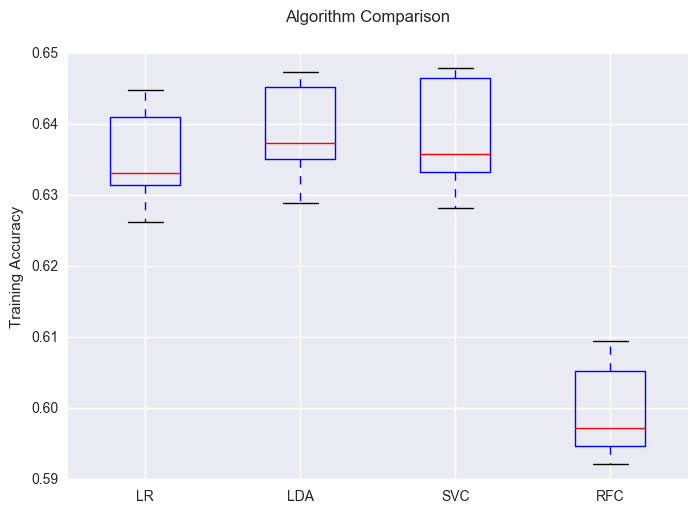

In [21]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.ylabel("Training Accuracy")
plt.show()

In [22]:
###############################################
## 5.5 PREDICTION OF MODELS
###############################################
from pandas_confusion import BinaryConfusionMatrix, Backend

Y_validationArray = Y_validation.as_matrix() # transfer to array

Pred_results = []
Accuracy_results =[]
predModels = []
md_names = []
BCM_results = []
classreports =[]
for name, model in models:
        predModel = model.fit(X_train, Y_train)
        pred_result = predModel.predict(X_validation)
        Pred_results.append(pred_result)
        predModels.append(predModel)
        md_names.append(name)
        accScore = accuracy_score(Y_validation, pred_result)
        Accuracy_results.append(accScore)
        BCM = BinaryConfusionMatrix(Y_validationArray, pred_result)
        BCM_results.append(BCM)
        cfr = classification_report(Y_validationArray, pred_result)
        classreports.append(cfr)     
        msg = "Prediction Accuracy %s: %0.3f" % (name, accScore)
        print "--------------------------------------------------"
        print  msg
        print  cfr
        print  BCM.print_stats()

--------------------------------------------------
Prediction Accuracy LR: 0.636
             precision    recall  f1-score   support

    helpful       0.62      0.75      0.68      5331
  unhelpful       0.67      0.52      0.58      5113

avg / total       0.64      0.64      0.63     10444

population: 10444
P: 5113
N: 5331
PositiveTest: 3964
NegativeTest: 6480
TP: 2639
TN: 4006
FP: 1325
FN: 2474
TPR: 0.516135341287
TNR: 0.75145376102
PPV: 0.665741675076
NPV: 0.618209876543
FPR: 0.24854623898
FDR: 0.334258324924
FNR: 0.483864658713
ACC: 0.636250478744
F1_score: 0.581469648562
MCC: 0.275648944849
informedness: 0.267589102307
markedness: 0.283951551619
prevalence: 0.489563385676
LRP: 2.07661698445
LRN: 0.64390476675
DOR: 3.22503744604
FOR: 0.381790123457
None
--------------------------------------------------
Prediction Accuracy LDA: 0.640
             precision    recall  f1-score   support

    helpful       0.62      0.75      0.68      5331
  unhelpful       0.67      0.52      0

In [23]:
from sklearn.metrics import roc_curve, auc
## transfer Y_validation to binary code
Y_validationBinary=[]
for i in range(0, len(Y_validationArray)):
    if Y_validationArray[i] =='helpful':
        bvb = 1 
    else:
        bvb = 0
    Y_validationBinary.append(bvb)

Probs = []
FPRs = []
TPRs = []
ROC_AUCs =[]
for k in range(0,len(predModels)):
    name = md_names[k]
    prob = predModels[k].predict_proba(X_validation)
    preds = prob[:,1]
    fpr, tpr, threshold = roc_curve(Y_validationBinary, preds, pos_label=0)
    roc_auc = auc(fpr, tpr)
    Probs.append(prob)
    FPRs.append(fpr)
    TPRs.append(tpr)
    ROC_AUCs.append(roc_auc)

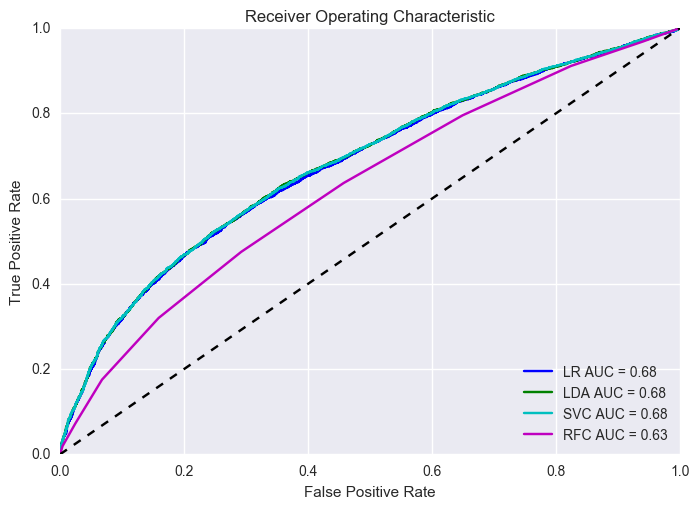

In [24]:
## plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(FPRs[0], TPRs[0], 'b', label='%s AUC = %0.2f'% (names[0],ROC_AUCs[0]))
plt.plot(FPRs[1], TPRs[1], 'g', label='%s AUC = %0.2f'% (names[1],ROC_AUCs[1]))
plt.plot(FPRs[2], TPRs[2], 'c', label='%s AUC = %0.2f'% (names[2],ROC_AUCs[2]))
plt.plot(FPRs[3], TPRs[3], 'm', label='%s AUC = %0.2f'% (names[3],ROC_AUCs[3]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
### ==> The result showed with default parameters, LR, LDA, and SVC have around 64% prediction accuracy for classifying helpful and unhelpful reviews. 

To understand whether the classifier based on the combination of several base estimators could improve the performance, we applied ensemble method for LDA + RFC and SVC + RFC.


In [32]:
###############################################
## 5.5 ENSEMBLES
###############################################

names_ens = []
FPRs_ens = []
TPRs_ens = []
ROC_AUCs_ens =[]

for k in range(1,(len(predModels)-1)): # LDA, SVC
    name = ''.join([md_names[k], '+' ,md_names[3]])
    prob = (Probs[k]+Probs[3])/2
    preds = prob[:,1]
    fpr, tpr, threshold = roc_curve(Y_validationBinary, preds, pos_label=0)
    roc_auc = auc(fpr, tpr)
    names_ens.append(name)
    FPRs_ens.append(fpr)
    TPRs_ens.append(tpr)
    ROC_AUCs_ens.append(roc_auc)


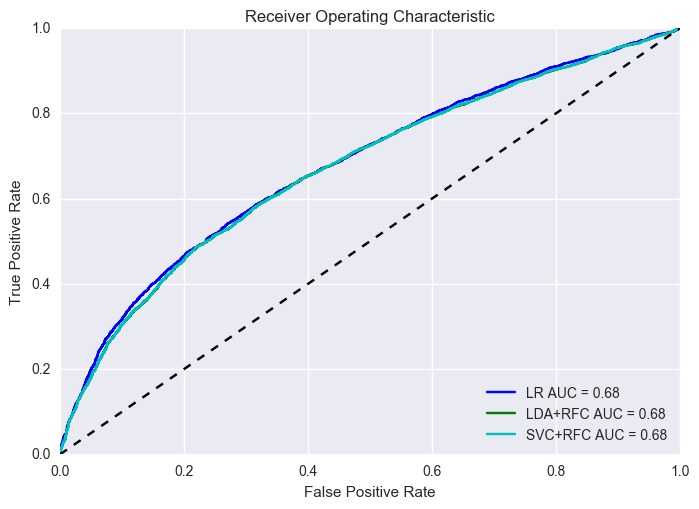

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(FPRs[0], TPRs[0], 'b', label='%s AUC = %0.2f'% (names[0],ROC_AUCs[0]))# plot LRC
plt.plot(FPRs_ens[0], TPRs_ens[0], 'g', label='%s AUC = %0.2f'% (names_ens[0],ROC_AUCs[1]))# plot LDA+RFC
plt.plot(FPRs_ens[1], TPRs_ens[1], 'c', label='%s AUC = %0.2f'% (names_ens[1],ROC_AUCs[2]))# plot SVC+RFC

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
### ==> The ensemble results of LDA + RFC and SVC + RFC showed similar performance compared to single LR model. Compared to single model (see the previous figure), the combination of multiple models did not improve the performance.

Next, we tested how the predict performance improves if we applied optimal parameters of each model.


In [25]:
###############################################
## 5.6 GET OPTIMAL PARAMETERS
###############################################

## get optimal parameters for LR 
C_range = np.random.normal(1, 0.2, 10).astype(float)
C_range[C_range < 0] = 0.0001

LR_best_c = None
LR_maxscore=-np.inf

start_time = timeit.default_timer()

for c in C_range:
    pipeline_LR = Pipeline([
      ('feature_union',  features),
      ('predictor', LogisticRegression(C=c, dual=False, fit_intercept=False, 
                                       intercept_scaling=1, penalty='l2', tol=0.0001))])        
    kf = KFold(X_train.shape[0], n_folds=5, random_state=seed) 
    cv_results = cross_val_score(pipeline_LR, 
                                 X_train, 
                                 Y_train, 
                                 cv=kf, 
                                 scoring='accuracy')
    cv_mean = cv_results.mean()
    if cv_mean > LR_maxscore:
        LR_maxscore = cv_mean
        LR_best_c = c

print("C_range:", C_range)
print("LR the best training performing score: {}".format(LR_maxscore))  
print("LR the best performing C value is: {}".format(LR_best_c))

elapsed = timeit.default_timer() - start_time

('C_range:', array([ 1.34411696,  1.23764362,  0.83505971,  1.09622855,  0.97651688,
        1.04588963,  1.02891314,  1.00598179,  0.66296639,  0.875974  ]))
LR the best training performing score: 0.629759990757
LR the best performing C value is: 1.34411696223


In [35]:
## get optimal parameters for SVC
C_range = np.random.normal(1, 0.1, 5).astype(float)

# Check that and C>0 
C_range[C_range < 0] = 0.0001

SVC_best_c = None
SVC_maxscore = -np.inf

for c in C_range:
    pipeline_SVC = Pipeline([
      ('feature_union',  features),
      ('predictor', CalibratedClassifierCV(LinearSVC(C = c)))])
    kf = KFold(X_train.shape[0], n_folds=5, random_state=seed) 
    cv_results = cross_val_score(pipeline_SVC, 
                                 X_train, 
                                 Y_train, 
                                 cv=kf, 
                                 scoring='accuracy')
    cv_mean = cv_results.mean()
    if cv_mean > SVC_maxscore:
        SVC_maxscore = cv_mean
        SVC_best_c = c

print("C_range:", C_range)
print("SVC the best training performing score: {}".format(SVC_maxscore))  
print("SVC the best performing C value is: {}".format(SVC_best_c))    

('C_range:', array([ 1.07898453,  1.03293608,  1.0850105 ,  1.0170868 ,  0.877263  ]))
SVC the best training performing score: 0.638295807478
SVC the best performing C value is: 1.03293607916


In [36]:
## get optimal parameters for RFC

# A larger leaf makes the model more prone to capturing real data in train data than noise itself
sample_leaf_options = [1,5,10,50,100,200,500]

RFC_leaf_size = None
RFC_maxscore = -np.inf


for leaf_size in sample_leaf_options :
    pipeline_RFC = Pipeline([
    ('feature_union',  features),
    ('predictor', RandomForestClassifier(n_estimators= 100, oob_score = True, n_jobs = -1,random_state =50,
                                         max_features = "auto", min_samples_leaf = leaf_size))])
    kf = KFold(X_train.shape[0], n_folds=5, random_state=seed) 
    cv_results = cross_val_score(pipeline_RFC, 
                             X_train, 
                             Y_train, 
                             cv=kf, 
                             scoring='accuracy')
    cv_mean = cv_results.mean()
    if cv_mean > RFC_maxscore:
        RFC_maxscore = cv_mean
        RFC_leaf_size = leaf_size

print("RFC the best training performing score: {}".format(RFC_maxscore))  
print("RFC the best performing leaf_size value is: {}".format(RFC_leaf_size))    


RFC the best training performing score: 0.641948343906
RFC the best performing leaf_size value is: 200


In [37]:
pipeline_LR = Pipeline([
      ('feature_union',  features),
      ('predictor', LogisticRegression(C=LR_best_c, dual=False, fit_intercept=False, 
                                       intercept_scaling=1, penalty='l2', tol=0.0001))])

pipeline_SVC = Pipeline([
      ('feature_union',  features),
      ('predictor', CalibratedClassifierCV(LinearSVC(C=SVC_best_c)))])

pipeline_RFC = Pipeline([
      ('feature_union',  features),
      ('predictor', RandomForestClassifier(n_estimators= 100, oob_score = True, n_jobs = -1,random_state =50,
                                         max_features = "auto", min_samples_leaf = RFC_leaf_size))])


In [38]:
opt_models = []
opt_models.append(('LR_optimalPars', pipeline_LR))
opt_models.append(('SVC_optimalPars', pipeline_SVC))
opt_models.append(('RFC_optimalPars', pipeline_RFC))

opt_predModels =[]

for name, opt_model in opt_models:
        predModel = opt_model.fit(X_train, Y_train)
        training_accuracy = opt_model.score(X_train, Y_train)
        pred_result = predModel.predict(X_validation)
        opt_predModels.append(predModel)
        accScore = accuracy_score(Y_validation, pred_result)
        #BCM = BinaryConfusionMatrix(Y_validationArray, pred_result)
        cfr = classification_report(Y_validationArray, pred_result)
        print "===================================================="
        print name
        print "accuracy on training data: %0.3f" % training_accuracy
        print "accuracy on test data:     %0.3f" % accScore
        print "--------------------------------------------------"
        print  cfr

LR_optimalPars
accuracy on training data: 0.630
accuracy on test data:     0.629
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.61      0.75      0.67      5331
  unhelpful       0.66      0.50      0.57      5113

avg / total       0.63      0.63      0.62     10444

SVC_optimalPars
accuracy on training data: 0.640
accuracy on test data:     0.639
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.62      0.75      0.68      5331
  unhelpful       0.67      0.53      0.59      5113

avg / total       0.64      0.64      0.63     10444

RFC_optimalPars
accuracy on training data: 0.651
accuracy on test data:     0.643
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.64      0.70      0.67      5331
  unhelpful       0.65      0.59      0.62      5113

avg / total

In [39]:
opt_FPRs = []
opt_TPRs = []
opt_ROC_AUCs =[]

for k in range(0,len(opt_models)):
    prob = opt_predModels[k].predict_proba(X_validation)
    preds = prob[:,1]
    fpr, tpr, threshold = roc_curve(Y_validationBinary, preds, pos_label=0)
    roc_auc = auc(fpr, tpr)
    opt_FPRs.append(fpr)
    opt_TPRs.append(tpr)
    opt_ROC_AUCs.append(roc_auc)

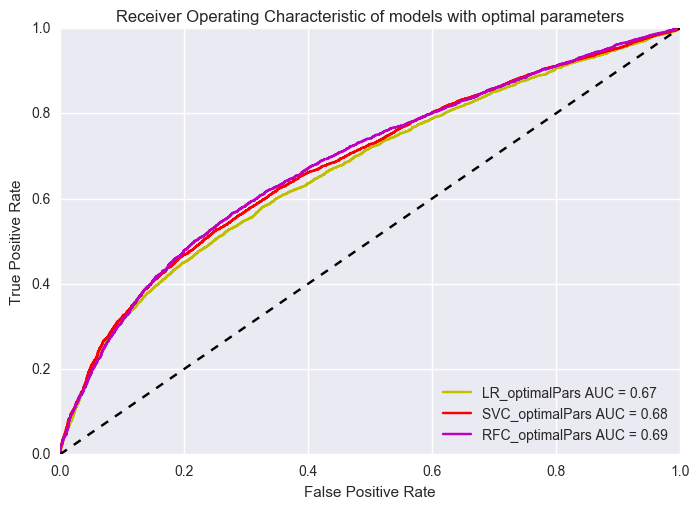

In [40]:
## plot ROC curve
plt.title('Receiver Operating Characteristic of models with optimal parameters')

plt.plot(opt_FPRs[0], opt_TPRs[0], 'y', label='%s AUC = %0.2f'% (opt_models[0][0],opt_ROC_AUCs[0]))
plt.plot(opt_FPRs[1], opt_TPRs[1], 'r', label='%s AUC = %0.2f'% (opt_models[1][0],opt_ROC_AUCs[1]))
plt.plot(opt_FPRs[2], opt_TPRs[2], 'm', label='%s AUC = %0.2f'% (opt_models[2][0],opt_ROC_AUCs[2]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
### When we selected optimal parameters of each model, all models achieved 64% prediction accuracy.

Next, to understand how the star rating, text length, and useful features of texts each feature affect the performance, we calculated the predicition accuracy of each single feature.

In [70]:
## treat star rating as feature
pipeline_LR = Pipeline([
      ('desc_rating_featurizer',  desc_rating_featurizer),
      ('predictor', LogisticRegression(C=LR_best_c, dual=False, fit_intercept=False, 
                                       intercept_scaling=1, penalty='l2', tol=0.0001))])

pipeline_SVC = Pipeline([
      ('desc_rating_featurizer',  desc_rating_featurizer),
      ('predictor', CalibratedClassifierCV(LinearSVC(C=SVC_best_c)))])

pipeline_RFC = Pipeline([
      ('desc_rating_featurizer',  desc_rating_featurizer),
      ('predictor', RandomForestClassifier(n_estimators= 100, oob_score = True, n_jobs = -1,random_state =50,
                                         max_features = "auto", min_samples_leaf = RFC_leaf_size))])


In [71]:
rating_models = []
rating_models.append(('LR_rating', pipeline_LR))
rating_models.append(('SVC_rating', pipeline_SVC))
rating_models.append(('RFC_rating', pipeline_RFC))

rating_predModels =[]
rating_accScore = []
for name, rating_model in rating_models:
        predModel = rating_model.fit(X_train, Y_train)
        training_accuracy = rating_model.score(X_train, Y_train)
        pred_result = predModel.predict(X_validation)
        rating_predModels.append(predModel)
        accScore = accuracy_score(Y_validation, pred_result)
        rating_accScore.append(accScore)
        cfr = classification_report(Y_validationArray, pred_result)
        print "===================================================="
        print name
        print "accuracy on training data: %0.3f" % training_accuracy
        print "accuracy on test data:     %0.3f" % accScore
        print "--------------------------------------------------"
        print  cfr

LR_rating
accuracy on training data: 0.622
accuracy on test data:     0.622
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.59      0.82      0.69      5331
  unhelpful       0.69      0.42      0.52      5113

avg / total       0.64      0.62      0.61     10444

SVC_rating
accuracy on training data: 0.622
accuracy on test data:     0.622
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.59      0.82      0.69      5331
  unhelpful       0.69      0.42      0.52      5113

avg / total       0.64      0.62      0.61     10444

RFC_rating
accuracy on training data: 0.622
accuracy on test data:     0.622
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.59      0.82      0.69      5331
  unhelpful       0.69      0.42      0.52      5113

avg / total       0.64    

In [72]:
## treat text length as feature
pipeline_LR = Pipeline([
      ('desc_length_featurizer',  desc_length_featurizer),
      ('predictor', LogisticRegression(C=LR_best_c, dual=False, fit_intercept=False, 
                                       intercept_scaling=1, penalty='l2', tol=0.0001))])

pipeline_SVC = Pipeline([
      ('desc_length_featurizer',  desc_length_featurizer),
      ('predictor', CalibratedClassifierCV(LinearSVC(C=SVC_best_c)))])

pipeline_RFC = Pipeline([
      ('desc_length_featurizer',  desc_length_featurizer),
      ('predictor', RandomForestClassifier(n_estimators= 100, oob_score = True, n_jobs = -1,random_state =50,
                                         max_features = "auto", min_samples_leaf = RFC_leaf_size))])


In [73]:
length_models = []
length_models.append(('LR_length', pipeline_LR))
length_models.append(('SVC_length', pipeline_SVC))
length_models.append(('RFC_length', pipeline_RFC))

length_predModels =[]
length_accScore = []
for name, length_model in length_models:
        predModel = length_model.fit(X_train, Y_train)
        training_accuracy = length_model.score(X_train, Y_train)
        pred_result = predModel.predict(X_validation)
        length_predModels.append(predModel)
        accScore = accuracy_score(Y_validation, pred_result)
        length_accScore.append(accScore)
        cfr = classification_report(Y_validationArray, pred_result)
        print "===================================================="
        print name
        print "accuracy on training data: %0.3f" % training_accuracy
        print "accuracy on test data:     %0.3f" % accScore
        print "--------------------------------------------------"
        print  cfr

LR_length
accuracy on training data: 0.557
accuracy on test data:     0.564
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.61      0.41      0.49      5331
  unhelpful       0.54      0.72      0.62      5113

avg / total       0.57      0.56      0.55     10444

SVC_length
accuracy on training data: 0.573
accuracy on test data:     0.581
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.60      0.55      0.57      5331
  unhelpful       0.57      0.62      0.59      5113

avg / total       0.58      0.58      0.58     10444

RFC_length
accuracy on training data: 0.588
accuracy on test data:     0.584
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.57      0.71      0.64      5331
  unhelpful       0.60      0.45      0.52      5113

avg / total       0.59    

In [60]:
## treat review text as feature

pipeline_LR = Pipeline([
      ('desc_tfidf_ngrams', desc_ngrams_featurizer),
      ('predictor', LogisticRegression(C=LR_best_c, dual=False, fit_intercept=False, 
                                       intercept_scaling=1, penalty='l2', tol=0.0001))])

pipeline_SVC = Pipeline([
      ('desc_tfidf_ngrams', desc_ngrams_featurizer),
      ('predictor', CalibratedClassifierCV(LinearSVC(C=SVC_best_c)))])

pipeline_RFC = Pipeline([
      ('desc_tfidf_ngrams', desc_ngrams_featurizer),
      ('predictor', RandomForestClassifier(n_estimators= 100, oob_score = True, n_jobs = -1,random_state =50,
                                         max_features = "auto", min_samples_leaf = RFC_leaf_size))])


In [61]:
tfidf_models = []
tfidf_models.append(('LR_tfidf', pipeline_LR))
tfidf_models.append(('SVC_tfidf', pipeline_SVC))
tfidf_models.append(('RFC_tfidf', pipeline_RFC))

tfidf_predModels =[]
tfidf_accScore = []
for name, tfidf_model in tfidf_models:
        predModel = tfidf_model.fit(X_train, Y_train)
        training_accuracy = tfidf_model.score(X_train, Y_train)
        pred_result = predModel.predict(X_validation)
        tfidf_predModels.append(predModel)
        accScore = accuracy_score(Y_validation, pred_result)
        tfidf_accScore.append(accScore)
        cfr = classification_report(Y_validationArray, pred_result)
        print "===================================================="
        print name
        print "accuracy on training data: %0.3f" % training_accuracy
        print "accuracy on test data:     %0.3f" % accScore
        print "--------------------------------------------------"
        print  cfr


LR_tfidf
accuracy on training data: 0.560
accuracy on test data:     0.554
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.55      0.72      0.62      5331
  unhelpful       0.57      0.38      0.46      5113

avg / total       0.56      0.55      0.54     10444

SVC_tfidf
accuracy on training data: 0.580
accuracy on test data:     0.579
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.57      0.76      0.65      5331
  unhelpful       0.61      0.39      0.47      5113

avg / total       0.59      0.58      0.56     10444

RFC_tfidf
accuracy on training data: 0.608
accuracy on test data:     0.586
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.58      0.70      0.63      5331
  unhelpful       0.60      0.47      0.53      5113

avg / total       0.59      0

---
### The above analysis showed single feature only achieved ~60% prediction performance regardless of models (star rating, text length, and review text had 62%, 57%, and ~57% performance, respectively). In our result, with a combination of three features, we could have better prediction of review helpfulness. 

In [42]:
#########################################
## 5.6 RANDOMIZE X_train and X_validation
#########################################
rand_X_train = X_train.iloc[np.random.permutation(len(X_train))].reset_index(drop=True)
rand_X_validation = X_validation.iloc[np.random.permutation(len(X_validation))].reset_index(drop=True)


In [43]:
### Used best model to train randomize data
### calculate accuracy for randomize training data

BaseModel = pipeline_LR
BaseModel.fit(rand_X_train, Y_train)
Base_training = BaseModel.score(rand_X_train, Y_train)
Base_test = BaseModel.predict(rand_X_validation)


In [44]:
print "Accuracy on shuffle training data: % 0.3f" % Base_training
print "Accuracy on shuffle test data: % 0.3f" % accuracy_score(Y_validation, Base_test)
print "--------------------------------------------------"
print classification_report(Y_validation, Base_test)

Accuracy on shuffle training data:  0.520
Accuracy on shuffle test data:  0.507
--------------------------------------------------
             precision    recall  f1-score   support

    helpful       0.51      0.82      0.63      5331
  unhelpful       0.49      0.18      0.26      5113

avg / total       0.50      0.51      0.45     10444



---
### ==> When we randomized the data, the prediction performance only around chance level. Our classifiers significantly classified the helpfulness of a review.

## 6. Conclusion 
In the current project, our goal is to build a model to predict the helpfulness of a review text. We randomly selected 100,000 reviews from Amazon book dataset. We treated a review as helpfulness if its' helpfulness rating was greater than 75% and others less than 75% as unhelpful. To avoid extreme data, we removed those reviews which have less than 2 votes from customers. Totally, the number between helpful and unhelpful reviews is equal (5331 and 5113, respectively).

We considered customers’ staring rating, length of the review text, and useful phrases of the review text to assess their helpfulness. For the useful information of a review, we considered 1,2 and 3 grams as phrases in a text. We used not only “bag of words” to remove non-letters and stop words but also tf-idf (term frequency, inverse document frequency) to get the weighting factors of each phrase.

We used 70% data as our training set and 30% as testing set. By testing four classifiers, Logistic Regression (LR), Linear Discriminant Analysis (LDA), LinearSVC (SVC), and Random Forest Classifier (RFC), we found that after adjusted the parameters in each model, four models showed better predict accuracy for helpfulness of a review (64%) compared to shuffled data (51%). The classification of helpfulness could not be detected by single feature. Because the balance number between helpful and unhelpful review, the result of the classifiers can not be due to the bias of class size. Indeed, we showed there are some patterns within data itself.

## 7. Future Works

We have seen that the classifiers gave the positive result for the classification of helpfulness of review texts. However, the predict accuracy probably did not achieve to the best performance. In the future work, it is necessary to compare different features or add  more features to ensure if we could enhance the prediction of helpfulness. The identify of helpful and unhelpful reviews is somehow arbitrary, therefore, further study is needed to manipulate different criteria of the helpful reviews to understand about online shopping behaviors.  

The current project could be extended to make the system more efficiently, such as real-time feedback to the customers’ comments by giving their helpfulness score or directly summarize the keywords of the helpful reviews of a product not just simple list the helpful review. In this way, it could also help customers to pick up the suitable product quickly among similar products.    

Some other issues of online shopping behaviors are worth to investigate in the future, such as, whether the helpfulness prediction could be varied among different categories of products, how the different review texts with similar helpfulness scores affect customers’ shopping attitude, and whether initial helpful review text affect the following reviews of each product. 